#Analysis of Cancer Gene Expression Data

#####Python main module imports for data analysis

In [2]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.stats import norm


# Math
import math

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Preprocessing Imports
from sklearn.preprocessing import normalize

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluating our ML results
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# For Spectral Clustering algorithms
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

# network imports
import networkx as nx
import igraph as ig

###Data Cleaning

#####Choose the data set:

In [3]:
# read data file
chooseData = raw_input("enter 'b' for breast cancer, 'l' for lynphoma cancer, or 'p' for prostate cancer: ")

if chooseData == 'b':
    datafile = '~/Documents/THESIS/project/ICOS_DATA/breast_preprocessed.txt'
elif chooseData == 'l':
    datafile = '~/Documents/THESIS/project/ICOS_DATA/dlbcl_preprocessed.txt'
else:
    datafile = '~/Documents/THESIS/project/ICOS_DATA/prostate_preprocessed.txt'

data = pd.read_table(datafile, delim_whitespace = True, 
                     dtype={'a': np.float64}, header = None)

enter 'b' for breast cancer, 'l' for lynphoma cancer, or 'p' for prostate cancer: b


/home/jcapitz/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# data dimension
print data.shape
# last 5 rows of the data
data.tail()

(47294, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
47289,lysA,5.68,5.7194,5.7592,5.6898,5.7236,5.662,5.6684,5.6742,5.6669,...,5.7164,5.7175,5.7133,5.7133,5.6753,5.6679,5.6692,5.7666,5.72,5.75
47290,pheA,5.705,5.6142,5.6955,5.6227,5.6727,5.5995,5.633,5.6539,5.6511,...,5.6595,5.6292,5.6042,5.6266,5.6022,5.6709,5.6136,5.6038,5.6693,5.5818
47291,thrB,5.7077,5.7586,5.7279,5.6777,5.6761,5.7091,5.6777,5.68,5.6763,...,5.6918,5.6501,5.5772,5.6637,5.6556,5.6587,5.6987,5.6933,5.6775,5.68
47292,trpF,5.6684,5.6585,5.6337,5.6427,5.6371,5.6691,5.62,5.6199,5.6608,...,5.6392,5.6451,5.6149,5.551,5.605,5.6246,5.5404,5.6206,5.6552,5.6141
47293,y,luminal,luminal,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,...,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,luminal,non-luminal,luminal


In [5]:
# extract colum names (all but last one are gene names).
colNames = data[0]
colNames = list(colNames)

In [6]:
# housekeepnig genes
hkfile = 'HK_exons.csv'

hkdata = pd.read_csv(hkfile)

hkdata.head()

hknames = hkdata['Gene Name']

hknames.head()


0    ACADVL
1    ACADVL
2    ACADVL
3    ACADVL
4    ACADVL
Name: Gene Name, dtype: object

In [7]:
len(hkdata)

65692

In [8]:
# Checking to see how many housekeeping genes in the dataset 
sum(hknames.isin(colNames))

0

In [9]:
# tranpose the data to have genes as columns and microarray experiment as rows
data2 = data.T.ix[1:]
data2.head()

,0,1,2,3,4,5,6,7,8,9,...,47284,47285,47286,47287,47288,47289,47290,47291,47292,47293
1,5.3416,5.846,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.5959,5.8873,5.8005,5.5931,5.746,5.68,5.705,5.7077,5.6684,luminal
2,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585,luminal
3,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337,luminal
4,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427,luminal
5,5.5385,5.8876,6.572,6.1651,8.8246,5.7474,5.821,7.4015,5.6479,5.8412,...,5.7101,5.8066,5.6583,5.7032,5.58,5.7236,5.6727,5.6761,5.6371,luminal


In [10]:
# reset the index to satrt at 0
data2 = data2.reset_index(drop=True)
data2.head()

,0,1,2,3,4,5,6,7,8,9,...,47284,47285,47286,47287,47288,47289,47290,47291,47292,47293
0,5.3416,5.846,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.5959,5.8873,5.8005,5.5931,5.746,5.68,5.705,5.7077,5.6684,luminal
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585,luminal
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337,luminal
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427,luminal
4,5.5385,5.8876,6.572,6.1651,8.8246,5.7474,5.821,7.4015,5.6479,5.8412,...,5.7101,5.8066,5.6583,5.7032,5.58,5.7236,5.6727,5.6761,5.6371,luminal


In [11]:
# add colum labels
data2.columns=colNames
data2.head()

,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF,y
0,5.3416,5.846,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.5959,5.8873,5.8005,5.5931,5.746,5.68,5.705,5.7077,5.6684,luminal
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585,luminal
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337,luminal
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427,luminal
4,5.5385,5.8876,6.572,6.1651,8.8246,5.7474,5.821,7.4015,5.6479,5.8412,...,5.7101,5.8066,5.6583,5.7032,5.58,5.7236,5.6727,5.6761,5.6371,luminal


In [12]:
# create date set with genes only. This is the features matrix
X = data2[range(data.shape[0]-1)]
print X.shape
# make sure data type is float and not string.
X = X.astype(float)
X.head()

(128, 47293)


,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9715-S,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF
0,5.3416,5.8460,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.7645,5.5959,5.8873,5.8005,5.5931,5.7460,5.6800,5.7050,5.7077,5.6684
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.8293,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.6392,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.7021,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427
4,5.5385,5.8876,6.5720,6.1651,8.8246,5.7474,5.8210,7.4015,5.6479,5.8412,...,5.8150,5.7101,5.8066,5.6583,5.7032,5.5800,5.7236,5.6727,5.6761,5.6371


In [13]:
# store the gene names/ids
geneNames = X.columns

In [14]:

# create vector with response variable
Y = data2[[-1]]
Y.head().dtypes

y    object
dtype: object

In [15]:
# make sure response vector is binary 0, 1.
Y = pd.get_dummies(Y)
Y.head(6)

,y_luminal,y_non-luminal
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1


In [16]:
# choose one of the equivalent response vectors.
Y = Y.ix[:,0]

In [17]:
np.mean(Y)

0.65625

In [18]:
Y = np.ravel(Y)

##Classification with Penalized Logistic Model

In [19]:
# model definition
# logistic regression with elasticnet regularization
# l1_ratio refers to alpha and alpha refers to lamba in Hastie
log_model = LogisticRegression(penalty = 'l1', C = 1/0.088371, fit_intercept = True)

###Significant Gene Selection Cross-Validation

In [29]:
fit_log_model = log_model.fit(X, Y)
coeffs = log_model.coef_
np.sum(coeffs[0]!=0)

2558

In [21]:
#initialize the dataframes for ranking genes
selected_genes = {'col1':'gene1'}
gene_names = DataFrame(geneNames)
gene_names.columns = ['trial0']

# Initial trial column 
gene_select_count = gene_names.isin(selected_genes)
gene_coeff = DataFrame()

# Number of trials
M = 500

# IN THE LOOP
for i in range(M):
    # Split the data

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


    # Fit model and select significant genes

    fit_log_model = log_model.fit(X_train, Y_train)
    #X_selected = fit_log_model.transform(X_test)


    # Find the indexes of significant genes

    # these are the index of the features selected by the l1 regularized logistic model
    selected_index = np.where(log_model.coef_!=0)[-1]
    # Selected genes in ith trial
    selected_genes = gene_names.loc[selected_index]

    gene_select_count['trial' + str(i)] = gene_names.isin(selected_genes)
    gene_coeff['trial' + str(i)] = Series(log_model.coef_[0])
    

In [22]:
beta_coeff = gene_coeff.mean(axis = 1)
beta_sterror = gene_coeff.std(axis = 1)
gene_imp_score = gene_coeff.mean(axis = 1).abs()
pvalue = 1-norm.cdf(np.abs(beta_coeff/beta_sterror))

In [23]:
# this creates a pandas Series with the sum of how many times a gene was selected
gene_select_summary = gene_select_count.sum(axis = 1)

gene_select_summary.head()

0     53
1     15
2    113
3    102
4     39
dtype: int64

In [24]:
# this data frame has the values for all genes
result = DataFrame([geneNames, gene_select_summary, gene_imp_score, beta_coeff, beta_sterror, pvalue], index = 
          ['Gene', 'Frequency', 'Score', 'Coefficient', 'Std Error', 'pvalue']).T.sort(['Frequency', 'Score'], 
                                                            ascending = False)

In [25]:
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head()

,Gene,Frequency,Coefficient,Std Error,pvalue
6695,GI_23065546-A,500,-0.1562347,0.06174137,0.005695485
6694,GI_23065543-I,500,-0.1315125,0.05225461,0.005921918
22089,GI_4503602-S,500,0.1033896,0.02735119,7.83905e-05
8926,GI_27734826-S,500,0.09535227,0.03061511,0.0009211309
11878,GI_31652248-S,500,-0.0882741,0.02810338,0.0008417186


In [26]:
# this gives the indices of selected genes according to some threshold. can use the importance score
# or the number of times selected.
selected_genes_index = gene_select_summary[beta_coeff != 0].index

In [27]:
result = DataFrame([geneNames[selected_genes_index], gene_select_summary[selected_genes_index], 
           gene_imp_score[selected_genes_index], beta_coeff[selected_genes_index], beta_sterror[selected_genes_index],
           pvalue[selected_genes_index]], index = ['Gene', 'Frequency', 'Score','Coefficient', 'Std Error', 
                                                   'pvalue']).T.sort(['Frequency', 'Score'], 
                                                                     ascending = False).head()

In [28]:
print len(selected_genes_index)
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head(10)

30259


,Gene,Frequency,Coefficient,Std Error,pvalue
5103,GI_23065546-A,500,-0.1562347,0.06174137,0.005695485
5102,GI_23065543-I,500,-0.1315125,0.05225461,0.005921918
15916,GI_4503602-S,500,0.1033896,0.02735119,7.83905e-05
6737,GI_27734826-S,500,0.09535227,0.03061511,0.0009211309
8793,GI_31652248-S,500,-0.0882741,0.02810338,0.0008417186


In [71]:
# these are the names of the selected genes
DataFrame(geneNames[selected_genes_index], columns = ['Selected Genes'], index = selected_genes_index).head()
len(DataFrame(geneNames[selected_genes_index], columns = ['Selected Genes'], index = selected_genes_index))

4785

In [72]:
#Need to create X_sel

X_sel = X[selected_genes_index]

X_sel.shape

(128, 4785)

In [73]:
# this gives the model's score
log_model.fit(X_sel,Y)
print log_model.score(X_sel,Y)

0.5


In [74]:
class_prob = log_model.predict_proba(X_sel)

In [75]:
class_prob.shape

(128, 2)

In [76]:
dfprob = DataFrame(class_prob)
print dfprob.mean()

0    0.843029
1    0.156971
dtype: float64


###Cross Validation

In [77]:
# Make a new log_model
#log_model2 = LogisticRegression()
log_model2 = LogisticRegression(dual = False, fit_intercept = True)

xvalacc = []
xvalROC = []
M = 1000

for i in range(M):

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_sel, Y)

    # Now fit the new model
    log_model2.fit(X_train, Y_train)

    # Predict the classes of the testing data set
    class_predict = log_model2.predict(X_test)

    # Compare the predicted classes to the actual test classes
    xvalacc.append(metrics.accuracy_score(Y_test,class_predict))
    try:
        xvalROC.append(roc_auc_score(Y_test,class_predict))
    except ValueError:
        pass

In [78]:
np.std(xvalacc)

0.050482051265771682

In [79]:
np.mean(xvalacc)

0.86812500000000004

In [80]:
np.std(xvalROC)

0.062058066839281334

In [81]:
np.mean(xvalROC)

0.84031881136954056

In [82]:
#Y_test = np.ones(20)
Y_test

array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  0.])

In [39]:
class_predict

array([ 1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.])

In [40]:
roc_auc_score(Y_test,class_predict)

0.88528138528138511

In [41]:
confusion_matrix(Y_test,class_predict)

array([[ 9,  2],
       [ 1, 20]])

In [42]:
np.cov(X_sel)

array([[ 2.33347593,  1.54124342,  1.80106029, ...,  1.64637966,
         0.94880161,  1.66242093],
       [ 1.54124342,  1.98828201,  1.83340177, ...,  1.22455284,
         0.93530213,  1.7564881 ],
       [ 1.80106029,  1.83340177,  2.37753582, ...,  1.36685781,
         1.09129885,  1.90201783],
       ..., 
       [ 1.64637966,  1.22455284,  1.36685781, ...,  2.647999  ,
         1.56140511,  1.45959456],
       [ 0.94880161,  0.93530213,  1.09129885, ...,  1.56140511,
         2.61945296,  0.64098437],
       [ 1.66242093,  1.7564881 ,  1.90201783, ...,  1.45959456,
         0.64098437,  2.50605199]])

##Classification with Random Forest

####Use MDI


In [43]:
# model definition
# random forest
rf_model = RandomForestClassifier(n_estimators = 500)

In [44]:
#initialize the dataframes for ranking genes
selected_genes = {'col1':'gene1'}
gene_names = DataFrame(geneNames)
gene_names.columns = ['trial0']

# Initial trial column 
gene_select_count = gene_names.isin(selected_genes)
gene_impurity = DataFrame()

# Number of trials
M = 100

# IN THE LOOP
for i in range(M):
    # Split the data

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


    # Fit model and select significant genes
    
    fit_rf_model = rf_model.fit(X, Y)
    
    # Find indexes of significant genes

    selected_index = np.where(rf_model.feature_importances_!=0)[-1]
    
    # Selected genes in ith trial
    
    selected_genes = gene_names.loc[selected_index]

    gene_select_count['trial' + str(i)] = gene_names.isin(selected_genes)
    gene_impurity['trial' + str(i)] = Series(rf_model.feature_importances_)


In [45]:
rf_model.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [46]:
gene_imp_score = gene_impurity.mean(axis = 1);
gene_imp_score = gene_imp_score.abs()

### this creates a pandas Series with the sum of how many times a gene was chosen
gene_select_summary = gene_select_count.sum(axis = 1)

gene_select_summary.head()

In [47]:
# this data frame has the values for all genes
DataFrame([geneNames, gene_select_summary, gene_imp_score], index = 
          ['Gene', 'Frequency', 'MDI']).T.sort(['MDI', 'Frequency'], 
                                                            ascending = False).head(10)

,Gene,Frequency,MDI
22089,GI_4503602-S,500,0.004186411
1800,GI_14249703-S,492,0.003414231
16849,GI_38146007-A,26,0.003132555
2518,GI_16507967-S,467,0.003047208
22149,GI_4503928-S,498,0.003002912
26033,GI_9951924-S,500,0.002914199
10064,GI_29738585-S,500,0.002826758
6483,GI_22748948-S,488,0.002743495
6671,GI_22779933-S,2,0.002642601
17275,GI_38455428-S,500,0.002566913


In [48]:
# this gives the indices of selected genes according to some threshold. can use the importance score
# or the number of times selected.
selected_genes_index = gene_select_summary[gene_imp_score >= 0.000125].index

In [49]:
print len(selected_genes_index)
DataFrame([geneNames[selected_genes_index], gene_select_summary[selected_genes_index], 
           gene_imp_score[selected_genes_index]], index = ['Gene', 'Frequency', 
                                                           'MDI']).T.sort(['MDI', 'Frequency'],
                                                                                  ascending = False).head()

1052


,Gene,Frequency,MDI
782,GI_4503602-S,500,0.004186411
75,GI_14249703-S,492,0.003414231
615,GI_38146007-A,26,0.003132555
107,GI_16507967-S,467,0.003047208
787,GI_4503928-S,498,0.003002912


In [50]:
#Need to create X_sel

X_sel = X[selected_genes_index]

X_sel.shape

(128, 1052)

In [51]:
# Make a new log_model
#log_model2 = LogisticRegression()
ensemble_model2 = RandomForestClassifier(n_estimators = 500)

xvalacc = []
xvalROC = []
M = 100

for i in range(M):

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_sel, Y)

    # Now fit the new model
    ensemble_model2.fit(X_train, Y_train)

    # Predict the classes of the testing data set
    class_predict = ensemble_model2.predict(X_test)

    # Compare the predicted classes to the actual test classes
    xvalacc.append(metrics.accuracy_score(Y_test,class_predict))
    try:
        xvalROC.append(roc_auc_score(Y_test,class_predict))
    except ValueError:
        pass

In [52]:
np.mean(xvalacc)

0.87749999999999995

In [53]:
np.mean(xvalROC)

0.84296792253459529

#Spectral Clustering

In [54]:
from sklearn.cluster import SpectralClustering
import matplotlib.cm as cm

In [55]:
spclus = SpectralClustering(affinity='nearest_neighbors', n_neighbors=20, n_clusters=2, assign_labels='discretize')
spclus_pred = spclus.fit_predict(X_sel.T)
print spclus_pred[:100]

[0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0
 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0]


In [56]:
spclus_pred.shape

(1052,)

####Need to create adjecency matrix.

In [57]:
W = kneighbors_graph(X_sel.T, 20, include_self=True)
print W[0]
print type(W)
print W.shape
print(W.todense)

  (0, 0)	1.0
  (0, 1051)	1.0
  (0, 329)	1.0
  (0, 450)	1.0
  (0, 1011)	1.0
  (0, 429)	1.0
  (0, 423)	1.0
  (0, 426)	1.0
  (0, 283)	1.0
  (0, 300)	1.0
  (0, 819)	1.0
  (0, 465)	1.0
  (0, 682)	1.0
  (0, 724)	1.0
  (0, 941)	1.0
  (0, 349)	1.0
  (0, 898)	1.0
  (0, 84)	1.0
  (0, 280)	1.0
  (0, 126)	1.0
<class 'scipy.sparse.csr.csr_matrix'>
(1052, 1052)
<bound method csr_matrix.todense of <1052x1052 sparse matrix of type '<type 'numpy.float64'>'
	with 21040 stored elements in Compressed Sparse Row format>>


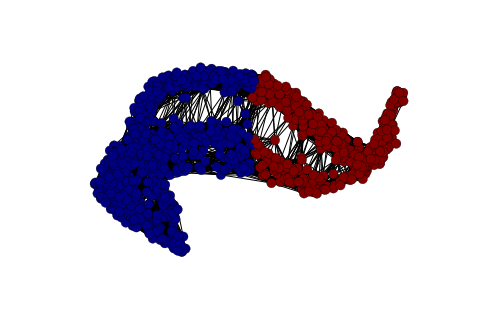

In [58]:
G = nx.from_scipy_sparse_matrix(W)
node_colors= spclus_pred
nx.draw(G, node_size = 90, node_color = spclus_pred, cmap = 'jet') # cmap=cm.RdYlGn)

In [59]:
X_sel.T.shape[0]

1052

In [60]:
X_sel2 = DataFrame.as_matrix(X_sel)
X_sel2[:,1]

array([ 6.9286,  6.3744,  7.0009,  6.9242,  6.6042,  5.9138,  5.9492,
        6.4743,  5.9561,  6.0311,  5.9379,  6.1718,  6.3482,  7.0314,
        6.41  ,  6.3318,  6.9734,  7.1704,  6.0093,  5.9706,  6.4635,
        6.0309,  5.9327,  6.0109,  6.3715,  6.3332,  6.0741,  6.2482,
        6.2126,  5.7967,  6.2235,  6.2909,  6.2885,  5.9264,  6.192 ,
        5.9799,  6.3838,  5.7666,  6.0259,  7.0307,  5.8527,  6.0883,
        5.9425,  5.6263,  6.1412,  5.8764,  6.4878,  5.9421,  5.8009,
        6.3144,  6.5489,  5.8124,  6.5641,  6.4215,  6.5443,  6.3921,
        6.0914,  5.9341,  6.4097,  6.0041,  6.5622,  5.9637,  5.607 ,
        6.5411,  6.3784,  6.6402,  6.3968,  5.683 ,  6.0456,  6.1246,
        6.3159,  5.9689,  5.6105,  5.8713,  6.3989,  6.3164,  6.4728,
        6.5783,  6.2955,  6.192 ,  6.7289,  6.5267,  6.7789,  6.2144,
        6.41  ,  5.6753,  5.9881,  6.5689,  5.7473,  6.6582,  5.9572,
        5.9799,  6.0703,  5.7136,  7.0588,  5.8196,  5.7467,  6.1195,
        6.3317,  7.0

In [61]:
#n = 50
#ncSample = numberClasses.loc[np.random.choice(numberClasses.index, n, replace=False)]

n = X_sel2.shape[1]
W = np.zeros((n,n))
print n
print X_sel2.shape
print W.shape
sigma = 1.25

for i in range(n):
    for j in range(n):
        W[i,j] = np.exp(-np.sum((X_sel2[:,i] - X_sel2[:,j])**2)/(2*sigma**2))
        
print W
print X_sel2.shape

1052
(128, 1052)
(1052, 1052)
[[  1.00000000e+00   3.26982603e-08   9.33695508e-17 ...,   6.39759705e-13
    8.38997846e-36   7.34570312e-02]
 [  3.26982603e-08   1.00000000e+00   5.39575379e-10 ...,   1.24335764e-17
    4.04227249e-19   2.05935560e-09]
 [  9.33695508e-17   5.39575379e-10   1.00000000e+00 ...,   4.11806175e-16
    3.43415756e-09   1.02519089e-19]
 ..., 
 [  6.39759705e-13   1.24335764e-17   4.11806175e-16 ...,   1.00000000e+00
    6.26293413e-37   1.11716526e-13]
 [  8.38997846e-36   4.04227249e-19   3.43415756e-09 ...,   6.26293413e-37
    1.00000000e+00   9.33221759e-40]
 [  7.34570312e-02   2.05935560e-09   1.02519089e-19 ...,   1.11716526e-13
    9.33221759e-40   1.00000000e+00]]
(128, 1052)


In [62]:
X_sel2[:,1]

array([ 6.9286,  6.3744,  7.0009,  6.9242,  6.6042,  5.9138,  5.9492,
        6.4743,  5.9561,  6.0311,  5.9379,  6.1718,  6.3482,  7.0314,
        6.41  ,  6.3318,  6.9734,  7.1704,  6.0093,  5.9706,  6.4635,
        6.0309,  5.9327,  6.0109,  6.3715,  6.3332,  6.0741,  6.2482,
        6.2126,  5.7967,  6.2235,  6.2909,  6.2885,  5.9264,  6.192 ,
        5.9799,  6.3838,  5.7666,  6.0259,  7.0307,  5.8527,  6.0883,
        5.9425,  5.6263,  6.1412,  5.8764,  6.4878,  5.9421,  5.8009,
        6.3144,  6.5489,  5.8124,  6.5641,  6.4215,  6.5443,  6.3921,
        6.0914,  5.9341,  6.4097,  6.0041,  6.5622,  5.9637,  5.607 ,
        6.5411,  6.3784,  6.6402,  6.3968,  5.683 ,  6.0456,  6.1246,
        6.3159,  5.9689,  5.6105,  5.8713,  6.3989,  6.3164,  6.4728,
        6.5783,  6.2955,  6.192 ,  6.7289,  6.5267,  6.7789,  6.2144,
        6.41  ,  5.6753,  5.9881,  6.5689,  5.7473,  6.6582,  5.9572,
        5.9799,  6.0703,  5.7136,  7.0588,  5.8196,  5.7467,  6.1195,
        6.3317,  7.0

In [63]:
spclus_pred

array([0, 0, 0, ..., 0, 1, 0])

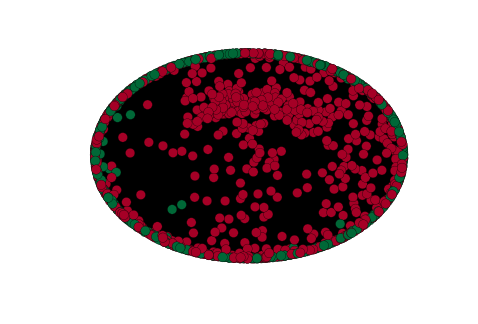

In [64]:
G = nx.Graph(W)
node_colors= spclus_pred
nx.draw(G, node_size = 90, node_color = spclus_pred, cmap=cm.RdYlGn)

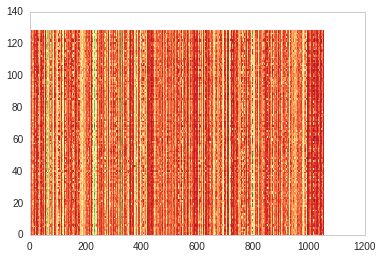

In [65]:
plt.pcolor(X_sel, cmap=cm.RdYlGn)
plt.show()

In [66]:
W[2,1]

5.3957537904267473e-10

In [67]:
#ax = sns.heatmap(X_sel)

In [68]:
data2.T.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
GI_10047089-S,5.3416,5.6259,5.6181,5.5602,5.5385,5.486,5.6556,5.8338,5.8608,5.7385,...,5.5907,5.5428,5.6417,5.5094,5.6826,5.6464,5.6538,5.6151,5.4363,5.5378
GI_10047091-S,5.846,5.8742,5.8026,5.8394,5.8876,5.8161,5.6843,5.7469,5.8936,5.7666,...,5.8654,6.1814,5.6987,6.0521,5.9005,5.7906,5.7275,5.8033,5.9836,5.8515
GI_10047093-S,6.7052,6.8089,6.6975,6.8386,6.572,6.7812,6.5955,6.5743,6.8306,7.1172,...,7.0968,6.615,6.8165,7.7491,6.8423,6.6567,6.578,7.094,7.0487,6.9199
GI_10047099-S,6.4184,6.6955,6.5851,6.7055,6.1651,6.3078,6.3591,6.1494,6.524,6.4357,...,5.9907,5.8993,5.862,5.9756,6.1138,5.8039,5.9087,5.881,6.0302,6.0595
GI_10047103-S,8.6651,8.6113,8.3808,8.4486,8.8246,8.0737,8.0979,8.0817,8.5717,8.5855,...,8.1376,8.4599,8.5959,8.4325,8.2017,8.5654,8.6179,8.6572,8.632,8.0838


In [69]:
data2.T.head()[0]['GI_10047089-S']

5.3416